# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

**Estudiante**: Daniel Merizalde Restrepo

**Datos del modelo final elegido**
* MAE test (DrivenData): 24.6563
* MAE validación: 20.3387 para San Juan y 7.3938 para Iquitos
* Algoritmo ML: Regresión Binomial Negativa
* Hiperparámetros:
* Lista de características:

  San Juan:

  * 'eightweek_mean_maxtemp_c'
  * 'station_max_temp_c'
  * 'eightweek_meansp_hum_g_kg'
  * 'reanalysis_specific_humidity_g_per_kg'
  * 'eightweek_mean_rel_hum'
  * 'reanalysis_relative_humidity_percent'
  * 'eightweek_meanpr_kg_m2'
  * 'reanalysis_precip_amt_kg_per_m2'
  * 'station_avg_temp_c'
  * 'reanalysis_max_air_temp_k'

  Iquitos:

  * 'sixweek_mean_mintemp_k'
  * 'reanalysis_min_air_temp_k'
  * 'fourweek_meansp_hum_g_kg'
  * 'reanalysis_specific_humidity_g_per_kg'
  * 'station_min_temp_c'
  * 'fourweek_meanpr_kg_m2'
  * 'reanalysis_precip_amt_kg_per_m2'
  * 'fourweek_mean_rel_hum'
  * 'reanalysis_relative_humidity_percent'
  * 'reanalysis_tdtr_k'

* Resumen dataset: Lista de transformaciones sobre los datos, cuyo proceso se puede evidenciar de mejor manera revisando las funciones "sj_data_preprocessing" e "iq_data_preprocessing":

* División por ciudades.
* Interpolación linear de los datos faltantes.
* Transformación de variable "week_start_date" de string a datetime.
* Borrado de variables "year" y "week_of_year".
* Creación de nuevas variables de tipo "Rolling".
* Creación de nueva variable para vegetación y generación de variable "Rolling" a partir de la misma.




---
# Resumen
---

Actividad número 2 de la materia Machine Learning, en donde se busca aplicar técnicas de aprendizaje supervisado aplicados al set de datos con variables climaticas en las ciudades de San Juan e Iquitos generado durante la actividad número 1. Las predicciones generadas durante la actividad serán subidas a la plataforma Driven Data, con el objetivo de obtener el menor puntaje de MAE posible.

La actividad se divide en 3 etapas:

1.   Inicialización del entorno y preprocesado de datos
2.   Revisión de características Actividad 1 y reselección teniendo en cuenta la variable objetivo
3.   Predicciones con diferentes modelos y selecciones de características





---
# Inicialización
---

In [1]:
# Instalación de librerías que no se encuentran por defecto en Colab:

!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.0 MB/s eta 0:00:00


In [2]:
# Imports generales

import pandas as pd
pd.options.mode.chained_assignment = None
import io
from google.colab import files
import seaborn as sbrn
from seaborn.rcmod import plotting_context
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import linear_model, neural_network
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures
from sklearn.model_selection import GridSearchCV

np.random.seed(970120)

In [3]:
# Definición de funciones para subida y descarga de archivos:

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    
    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

In [8]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)
train_feat = upload_files()
print(train_feat.shape)
train_feat.head(2)

Saving dengue_features_train.csv to dengue_features_train (2).csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.1699,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6


In [9]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head(2)

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes
(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.1699,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5


In [10]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = upload_files()
print(test.shape)
test.head(2)

Saving dengue_features_test.csv to dengue_features_test (1).csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes
(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.0189,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.0124,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3


---
# Preprocesado
---

A partir de los reslutados de la actividad número 1 de la materia, se cuenta con la función "dengAI_data_preprocessing", que realiza transformaciones sobre los datos, crea nuevas variables a partir de las existentes y elimina las variables que se consideraban redundantes. Sin embargo, durante el análisis realizado en la actididad 1 no se contaba con la variable objetivo "total_cases".

Teniendo en cuenta que ya se cuenta con la variable objetivo para revisar correlaciones y capacidad predictiva de los datos, se plantea tomar las bases de la función obtenida durante la actividad número 1 y modificarla para poder obtener el mayor valor predictivo posible de las variables.

In [11]:
# TRAIN

# División de DataFrames por ciudades:

group = train.groupby(train.city)
sj_data = group.get_group("sj")
iq_data = group.get_group("iq")

# Rellenado de valores perdidos:

sj_data.interpolate(method="linear", inplace=True)
iq_data.interpolate(method="linear", inplace=True)

# Transformación y borrado de variables de tiempo:

sj_data['week_start_date'] = sj_data['week_start_date'].str.replace("-", "")
sj_data['week_start_date'] = pd.to_datetime(sj_data['week_start_date'], format='%Y%m%d')
sj_data.drop(["year", "weekofyear"], axis = 1, inplace = True)

iq_data['week_start_date'] = iq_data['week_start_date'].str.replace("-", "")
iq_data['week_start_date'] = pd.to_datetime(iq_data['week_start_date'], format='%Y%m%d')
iq_data.drop(["year", "weekofyear"], axis = 1, inplace = True)

print("SJ trainData: ", sj_data.shape, "IQ trainData: ", iq_data.shape)

SJ trainData:  (936, 23) IQ trainData:  (520, 23)


In [12]:
# TEST

# División de DataFrames por ciudades:

group = test.groupby(test.city)
sj_test_data = group.get_group("sj")
iq_test_data = group.get_group("iq")

# Rellenado de valores perdidos:

sj_test_data.interpolate(method="linear", inplace=True)
iq_test_data.interpolate(method="linear", inplace=True)

# Transformación y borrado de variables de tiempo:

sj_test_data['week_start_date'] = sj_test_data['week_start_date'].str.replace("-", "")
sj_test_data['week_start_date'] = pd.to_datetime(sj_test_data['week_start_date'], format='%Y%m%d')
sj_test_data.drop(["year", "weekofyear"], axis = 1, inplace = True)

iq_test_data['week_start_date'] = iq_test_data['week_start_date'].str.replace("-", "")
iq_test_data['week_start_date'] = pd.to_datetime(iq_test_data['week_start_date'], format='%Y%m%d')
iq_test_data.drop(["year", "weekofyear"], axis = 1, inplace = True)

print("SJ testData: ", sj_test_data.shape, "IQ testData: ", iq_test_data.shape)

SJ testData:  (260, 22) IQ testData:  (156, 22)


Se aplica una división de los datos por ciudades con el objetivo de generar variables específicas para cada una y poder obtener mayor precisión en las predicciones generadas.

Se usa interpolación lineal para reemplazar los valores vacíos en cada DataFrame y se transforma la variable 'week_start_date' al tipo datetime para que sirva como única variable de tiempo; ya que se cuenta con esta variable para describir el tiempo en el que se toman las muestras, las variables 'year' y 'weekofyear' son borradas de los DataFrames.

---
# Características
---

<Axes: title={'center': 'casos totales en SAN JUAN 1990-2008'}, xlabel='week_start_date'>

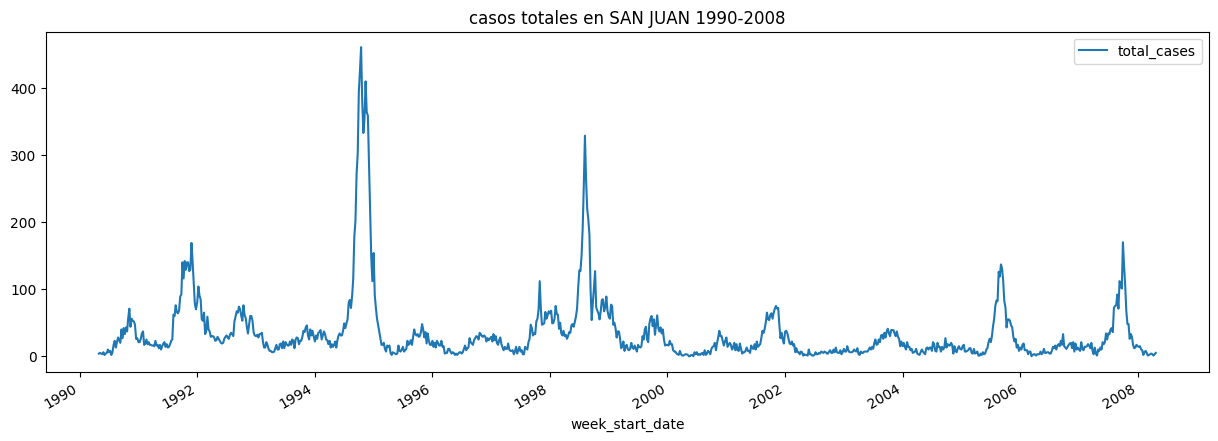

In [13]:
# Gráfico para visualizar casos totales en SAN JUAN a través del tiempo:

sj_data.plot(x = "week_start_date", y = "total_cases", figsize=(15,5), title = "casos totales en SAN JUAN 1990-2008")

<Axes: title={'center': 'casos totales en IQUITOS 200-2012'}, xlabel='week_start_date'>

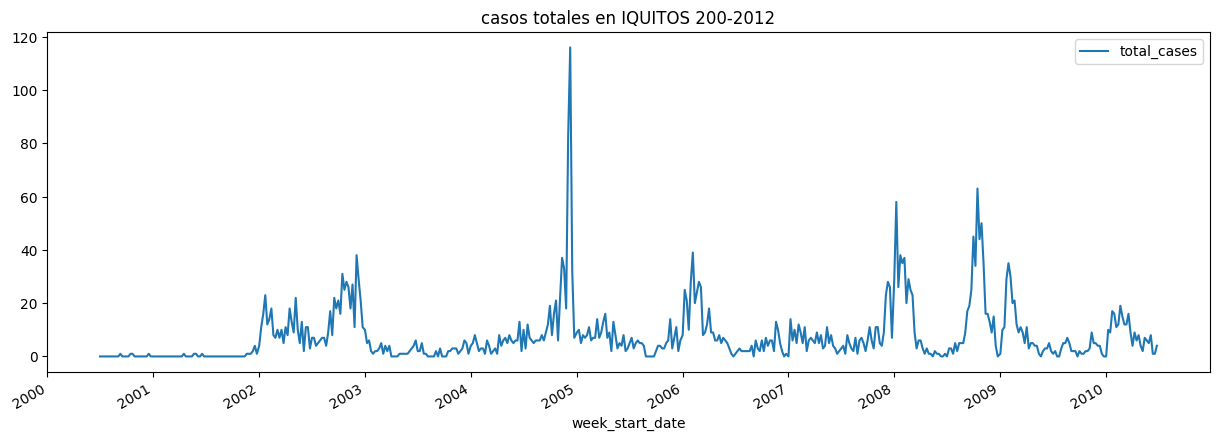

In [14]:
# Gráfico para visualizar casos totales en IQUITOS a través del tiempo:

iq_data.plot(x = "week_start_date", y = "total_cases",figsize=(15,5), title = "casos totales en IQUITOS 200-2012")

Se generan gráficos de los casos totales en ambas ciuadades con el objetivo de conocer la distribución y posibles tendencias de los datos.

A simple vista se puede observar que la mayor parte del tiempo los casos son pocos, pero que pueden generarse picos de contagio en donde se alcanza un número alto de casos totales. Los gráficos generados no parecen demostrar tendencias o estacionalidades.



Text(0.5, 1.0, 'Correlaciones con "total_cases" SAN JUAN')

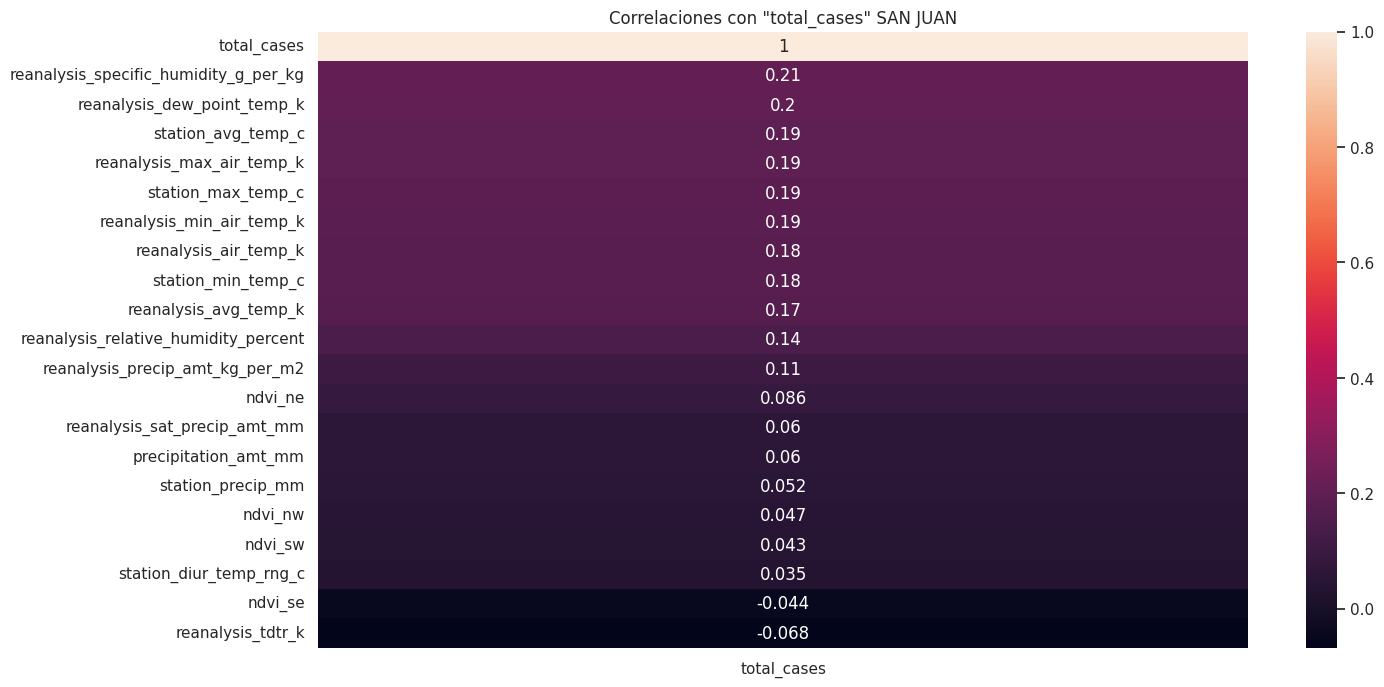

In [15]:
# Mapa de calor para revisar correlaciones con variable objetivo SAN JUAN

corr = sj_data.corr(numeric_only = True)
total_cases_corr = corr[["total_cases"]]
sbrn.set(rc = {'figure.figsize':(15,8)})
heatmap = sbrn.heatmap(total_cases_corr.sort_values(by = ["total_cases"], ascending = False), annot = True)
plt.title('Correlaciones con "total_cases" SAN JUAN')

Text(0.5, 1.0, 'Correlaciones con "total_cases" IQUITOS')

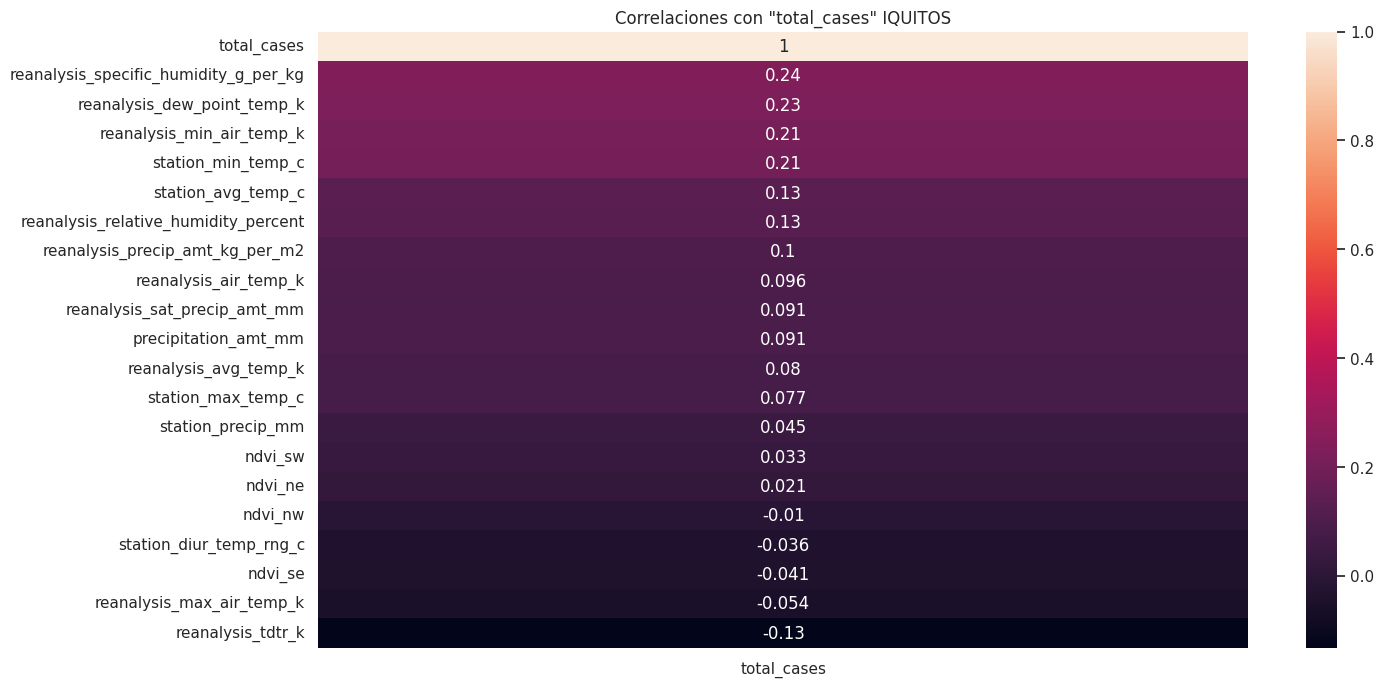

In [16]:
# Mapa de calor para revisar correlaciones con variable objetivo IQUITOS

corr = iq_data.corr(numeric_only = True)
total_cases_corr = corr[["total_cases"]]
sbrn.set(rc = {'figure.figsize':(15,8)})
heatmap = sbrn.heatmap(total_cases_corr.sort_values(by = ["total_cases"], ascending = False), annot = True)
plt.title('Correlaciones con "total_cases" IQUITOS')

Durante la actividad 1 se había planteado una selección de variables basada en los análisis de PCA y en la conservación de los cuatro grupos generales de información (Temperatura, húmedad, pluviosidad y vegetación). Al tener acceso a la variable objetivo "total_cases" se pueden corroborar o descartar aspectos de esta selección.

Por ejemplo, las variables de vegetación no parecen tener una alta correlación sea positiva o negativa con los casos de dengue en ambas ciudades.

In [17]:
# Definición de función para preprocesado SAN JUAN basada en Actividad 1 y mapa de correlación:

def sj_data_preprocessing (input_df, normalize = False, tc = True, drop_datetime = True):

  standard_scaler = StandardScaler()
  minmax_scaler = MinMaxScaler()

  df = input_df.copy()

  df.drop(["city"], axis = 1, inplace = True)
  if drop_datetime == True:
    df.drop(["week_start_date"], axis = 1, inplace = True)

  # Generación de nuevas variables "Rolling":

  df["eightweek_meanpr_kg_m2"] = df["reanalysis_precip_amt_kg_per_m2"].rolling(8, min_periods = 1).mean()
  df["eightweek_meansp_hum_g_kg"] = df["reanalysis_specific_humidity_g_per_kg"].rolling(8, min_periods = 1).mean()
  df["eightweek_mean_maxtemp_c"] = df["station_max_temp_c"].rolling(8, min_periods = 1).mean()
  df["eightweek_mean_rel_hum"] = df["reanalysis_relative_humidity_percent"].rolling(8, min_periods = 1).mean()

  # Generación de nuevas variables de vegetación:

  df['min_ndvi'] = df[['ndvi_ne','ndvi_nw', 'ndvi_se', 'ndvi_sw']].min(axis=1)
  df["eightweek_min_ndvi"] = df["min_ndvi"].rolling(8, min_periods = 1).mean()

  if tc == True:
    tc = df['total_cases']
    df.drop(labels=['total_cases'], axis=1,inplace = True)

  if normalize == True:
    minmax_scaler.fit(df)
    scaled = minmax_scaler.fit_transform(df)
    df = pd.DataFrame(scaled, columns = df.columns)

  return df, tc

Teniendo en cuenta que los ciclos de vida del Aedes aegypti pueden ser de hasta 2 meses, y que los huevos que son depositados en cuencas secas también pueden sobrevivir varios meses hasta que son cubiertos por agua, se generan 2 hipótesis:

1.   Una temporada seca seguida por mediciones de altas precipitaciones puede significar un pico en casos de contagio por la eclosión simultanea de grandes cantidades de huevos que estaban secos hasta el momento.
2.   A pesar de no tener mediciones de alta húmedad y temperatura en una semana especifica, podría haber grandes grupos de mosquitos que eclosionaron en semanas pasadas en donde las condiciones fueron mejores.

Para abordar estas hipótesis se generan las veriables de tipo "Rolling", que toman las medidas generadas durante un número específico de semanas y promedian sus valores.

Otra parte importante de esta función es la generación de nuevas variables de vegetación, que buscan generar mejores valores de correlación. Para esto se crea la variable "min_ndvi" y se promedian sus valores, ya que en teoría menores valores de ndvi indican más agua estancada en los alrededores de las ciudades.




In [18]:
sj_raw_train, sj_raw_tc = sj_data_preprocessing(sj_data)
sj_scaled_train, sj_scaled_tc = sj_data_preprocessing(sj_data, normalize = True)

Se generan DataFrames para la ciudad de San Juan tanto con los datos crudos como normalizados, con la intención de realizar varias predicciones usando ambas opciones de datos de entrada y revisar cual obtiene mejores resultados. Posteriormente se hará lo mismo con la ciudad de Iquitos.

Text(0.5, 1.0, 'Correlaciones con "total_cases" SAN JUAN MODIFICADO')

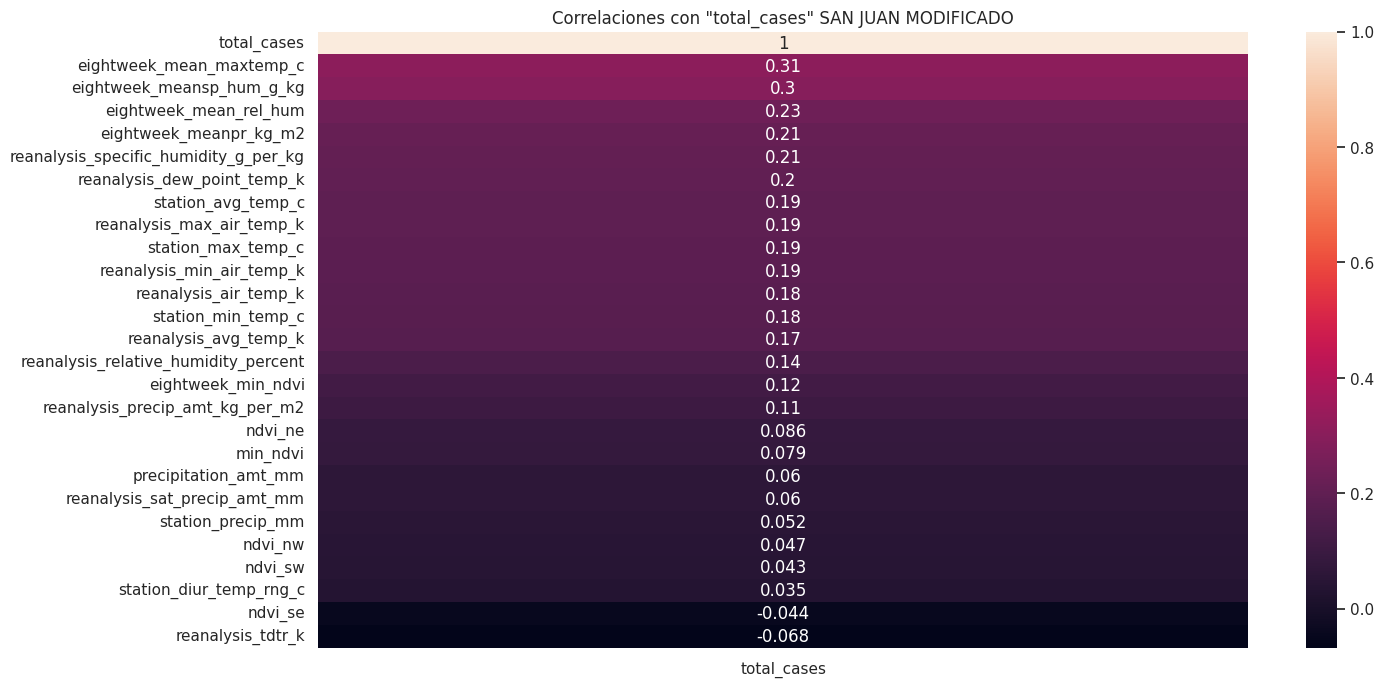

In [19]:
sj_corr_df = sj_raw_train.copy()
sj_corr_df.insert(0, "total_cases", sj_raw_tc)

corr = sj_corr_df.corr(numeric_only = True)
total_cases_corr = corr[["total_cases"]]
sbrn.set(rc = {'figure.figsize':(15,8)})
heatmap = sbrn.heatmap(total_cases_corr.sort_values(by = ["total_cases"], ascending = False), annot = True)
plt.title('Correlaciones con "total_cases" SAN JUAN MODIFICADO')

Según lo observado en el mapa de correlaciones modificado, las nuevas variables de tipo "Rolling" cumplen con su función y presentan mejores niveles de correlación que sus contrapartes unisemanales. A partir de los primeros resultados se ajusta el número de semanas hesta llegar a 8, que parece ser el valor que genera mejores correlaciones y se mantiene dentro del rango de ciclo de vida de los mosquitos.

En cuanto a las nuevas variables de vegetación como "eightweek_min_ndvi", se logra aumentar los valores de correlación considerablemente.

In [20]:
# Definición de función para preprocesado IQUITOS basada en Actividad 1 y mapa de correlación:

def iq_data_preprocessing (input_df, normalize = False, tc = True, drop_datetime = True):

  minmax_scaler = MinMaxScaler()

  df = input_df.copy()

  df.drop(["city"], axis = 1, inplace = True)
  if drop_datetime == True:
    df.drop(["week_start_date"], axis = 1, inplace = True)

  # Generación de nuevas variables "Rolling":

  df["fourweek_meanpr_kg_m2"] = df["reanalysis_precip_amt_kg_per_m2"].rolling(4, min_periods = 1).mean()
  df["fourweek_meansp_hum_g_kg"] = df["reanalysis_specific_humidity_g_per_kg"].rolling(4, min_periods = 1).mean()
  df["sixweek_mean_mintemp_k"] = df["reanalysis_min_air_temp_k"].rolling(6, min_periods = 1).mean()
  df["fourweek_mean_rel_hum"] = df["reanalysis_relative_humidity_percent"].rolling(4, min_periods = 1).mean()

  # Generación de nuevas variables de vegetación:

  df['min_ndvi'] = df[['ndvi_ne','ndvi_nw', 'ndvi_se', 'ndvi_sw']].min(axis=1)
  df["fourweek_min_ndvi"] = df["min_ndvi"].rolling(4, min_periods = 1).mean()
  
  if tc == True:
    tc = df['total_cases']
    df.drop(labels=['total_cases'], axis=1,inplace = True)

  if normalize == True:
    minmax_scaler.fit(df)
    scaled = minmax_scaler.fit_transform(df)
    df = pd.DataFrame(scaled, columns = df.columns)

  return df, tc

In [21]:
# Generación de DataFrames crudo y normalizado.

iq_raw_train, iq_raw_tc = iq_data_preprocessing(iq_data)
iq_scaled_train, iq_scaled_tc = iq_data_preprocessing(iq_data, normalize = True)

Text(0.5, 1.0, 'Correlaciones con "total_cases" IQUITOS MODIFICADO')

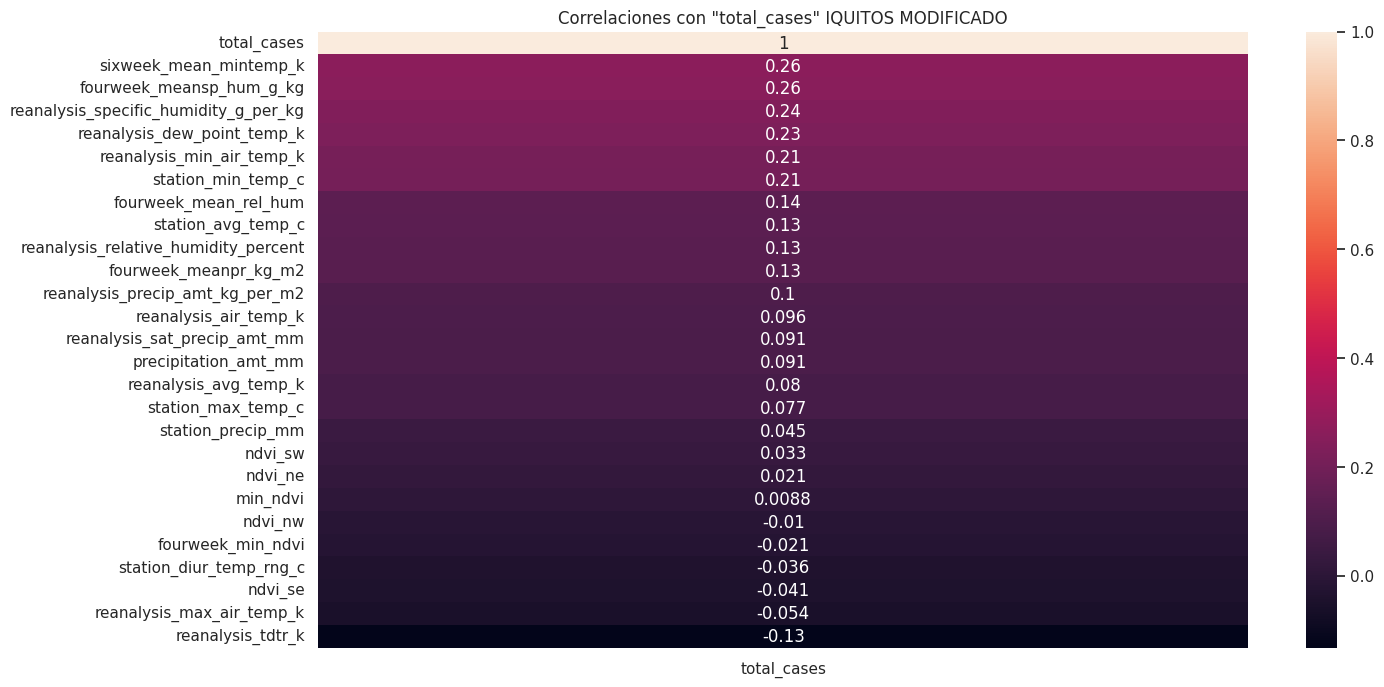

In [22]:
iq_corr_df = iq_raw_train.copy()
iq_corr_df.insert(0, "total_cases", iq_raw_tc)

corr = iq_corr_df.corr(numeric_only = True)
total_cases_corr = corr[["total_cases"]]
sbrn.set(rc = {'figure.figsize':(15,8)})
heatmap = sbrn.heatmap(total_cases_corr.sort_values(by = ["total_cases"], ascending = False), annot = True)
plt.title('Correlaciones con "total_cases" IQUITOS MODIFICADO')

Las variables de tipo "Rolling" son ajustados a mano hasta obtener los mejores valores de correlación posible, y de nuevo muestran ser beneficiosas para la actividad, al generar mejores medidas de correlación con los casos totales que sus contrapartes unisemanales, con la exepción de la variable 'fourweek_min_ndvi', que presenta valores de correlación muy cercanos a 0.


In [23]:
# Preprocesado de los DataFrames de Test:

sj_raw_test, y = sj_data_preprocessing(sj_test_data, tc = False)
iq_raw_test, y = iq_data_preprocessing(iq_test_data, tc = False)

sj_scaled_test, y = sj_data_preprocessing(sj_test_data, normalize = True, tc = False)
iq_scaled_test, y = iq_data_preprocessing(iq_test_data, normalize = True, tc = False)

A partir de los resultados obtenidos anteriormente y los ajustes realizados sobre las funciones de preprocesado, se aplican las mismas funciones a los DataFrames del conjunto "Test", para poder contar con las mismas variables tanto en el entrenamiento como en las predicciones de los modelos.

In [24]:
# Selección de variables para entrenamiento en ambos dataframes (IQ y SJ)

sj_sel_features = ['eightweek_mean_maxtemp_c', \
                   'station_max_temp_c', \
                   'eightweek_meansp_hum_g_kg', \
                   'reanalysis_specific_humidity_g_per_kg', \
                   'eightweek_mean_rel_hum', \
                   'reanalysis_relative_humidity_percent', \
                   'eightweek_meanpr_kg_m2', \
                   'reanalysis_precip_amt_kg_per_m2', \
                   'station_avg_temp_c', \
                   'reanalysis_max_air_temp_k']

iq_sel_features = ['sixweek_mean_mintemp_k', \
                   'reanalysis_min_air_temp_k', \
                   'fourweek_meansp_hum_g_kg', \
                   'reanalysis_specific_humidity_g_per_kg', \
                   'station_min_temp_c', \
                   'fourweek_meanpr_kg_m2', \
                   'reanalysis_precip_amt_kg_per_m2', \
                   'fourweek_mean_rel_hum', \
                   'reanalysis_relative_humidity_percent', \
                   'reanalysis_tdtr_k']

Se hace una selección de variables basada en los puntajes obtenidos durante los análisis de correlación.

Es importante resaltar que en caso de que una de las variables de tipo "Rolling" sea seleccionada, la variable original que se usa para crearla también será elegida, esto se hace con el objetivo de que los modelos tengan tanto los promedios de semanas anteriores como los valores de la semana actual que se está evaluando y obtener mejor diferenciación de las predicciones semana a semana, ya que es posible que utilizar únicamente las variables de tipo "Rolling" genere resultados con menor varianza de semana a semana.

In [25]:
# División datos de Train, Test y Cross Validation SAN JUAN e IQUITOS con variables crudas

X_train_rawSJ = sj_raw_train[sj_sel_features]
X_test_rawSJ = sj_raw_test[sj_sel_features]
X_sj_raw_crosv, y_sj_crosv = X_train_rawSJ[750:], sj_raw_tc[750:]
print(X_sj_raw_crosv.shape, y_sj_crosv[0:3])

print("---")

X_train_rawIQ = iq_raw_train[iq_sel_features]
X_test_rawIQ = iq_raw_test[iq_sel_features]
X_iq_raw_crosv, y_iq_crosv = X_train_rawIQ[360:], iq_raw_tc[360:]
print(X_iq_raw_crosv.shape, y_iq_crosv[0:3])

cosv_tc  = y_sj_crosv.combine_first(y_iq_crosv)

(186, 10) 750    13
751    18
752    16
Name: total_cases, dtype: int64
---
(160, 10) 1296    4
1297    3
1298    1
Name: total_cases, dtype: int64


In [26]:
# División datos de entrenamiento, test y CrossValidation SAN JUAN e IQUITOS con variables normalizadas

X_train_norSJ = sj_scaled_train[sj_sel_features]
X_test_norSJ = sj_scaled_test[sj_sel_features]
X_sj_scaled_crosv, y_sj_crosv = X_train_norSJ[750:], sj_scaled_tc[750:]
print(X_sj_scaled_crosv.shape, y_sj_crosv[0:3])

print("---")

X_train_norIQ = iq_scaled_train[iq_sel_features]
X_test_norIQ = iq_scaled_test[iq_sel_features]
X_iq_scaled_crosv, y_iq_crosv = X_train_norIQ[360:], iq_scaled_tc[360:]
print(X_iq_scaled_crosv.shape, y_iq_crosv[0:3])

(186, 10) 750    13
751    18
752    16
Name: total_cases, dtype: int64
---
(160, 10) 1296    4
1297    3
1298    1
Name: total_cases, dtype: int64


Se hace la división de los datos para poder realizar predicciones sobre el DataFrame de cross validation y revisar la precisión de los modelos realizados de manera local antes de subirlos a la plataforma de la competición.

---
# Predicciones
---

Antes de comenzar con los modelos de predicción se realizan consultas en la web para conocer que modelos han tenido mejores resultados para predecir casos de enfermedades símilares al dengue y revisar que tan compleja podría ser su implementación, a continuación, se muestran algunos de los sitios web consultados:

* https://paul-mora.com/time%20series/python/DengAI-Predicting-Disease-Spread-Imputation-and-Stationarity-Problems/

* https://www.mdpi.com/2504-4990/5/1/13

* https://dataconomy.com/2022/11/time-series-forecasting-machine-learning/

* https://github.com/ngbolin/DengAI/blob/master/DengAI.ipynb 

## Regresión lineal (DATOS CRUDOS - VAR REDUCIDAS)


In [27]:
# Revisiones del modelo de Regresión Lineal con datos de Cross Validation:

sj_crossval = linear_model.LinearRegression()
sj_crossval.fit(X_train_rawSJ[0:750], sj_raw_tc[0:750])

iq_crossval = linear_model.LinearRegression()
iq_crossval.fit(X_train_rawIQ[0:360], iq_raw_tc[0:360])
# Predicciones sobre el conjunto de Cross Validation y organización en una lista:

y_pred_sj_rawCV = sj_crossval.predict(X_sj_raw_crosv[sj_sel_features])
y_pred_iq_rawCV = iq_crossval.predict(X_iq_raw_crosv[iq_sel_features])

y_pred_raw_linregCV = []

for pred in y_pred_sj_rawCV:
  if pred > 0:
    y_pred_raw_linregCV.append(int(pred))
  else:
    y_pred_raw_linregCV.append(0)

for pred in y_pred_iq_rawCV:
  if pred > 0:
    y_pred_raw_linregCV.append(int(pred))
  else:
    y_pred_raw_linregCV.append(0)

In [28]:
# Calcular MAE apróximado para el modelo:

CV_LRM_mae = eval_measures.meanabs(y_pred_raw_linregCV, cosv_tc)
print("MAE Validación raw_LRM: ", CV_LRM_mae)

MAE Validación raw_LRM:  17.447976878612717


In [29]:
# Ejecución del algoritmo de ML LinearRegression y generación de su modelo
# Nombre del modelo: "raw_LRM"
# Resultado MAE: 25.03

sj_model = linear_model.LinearRegression()
sj_model.fit(sj_raw_train[sj_sel_features], sj_raw_tc)

iq_model = linear_model.LinearRegression()
iq_model.fit(iq_raw_train[iq_sel_features], iq_raw_tc)

# Predicción sobre el conjunto de test
y_pred_sj_raw = sj_model.predict(sj_raw_test[sj_sel_features])
y_pred_iq_raw = iq_model.predict(iq_raw_test[iq_sel_features])

In [30]:
# Convertir valores a enteros y valores negativos a 0:

y_pred_raw_linreg = []

for pred in y_pred_sj_raw:
  if pred > 0:
    y_pred_raw_linreg.append(int(pred))
  else:
    y_pred_raw_linreg.append(0)

for pred in y_pred_iq_raw:
  if pred > 0:
    y_pred_raw_linreg.append(int(pred))
  else:
    y_pred_raw_linreg.append(0)

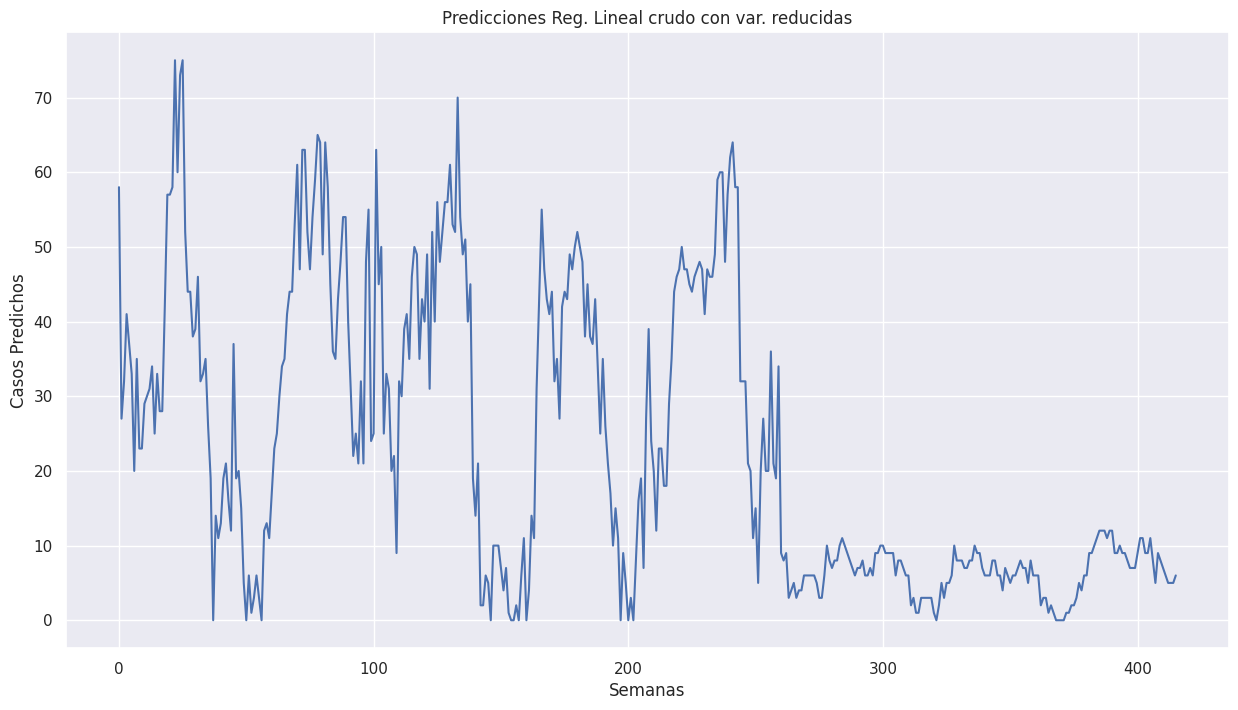

In [31]:
# Reformatear resultados para poderlos descargar
res_linear_model_raw = np.hstack(y_pred_raw_linreg)


plt.plot(res_linear_model_raw)
plt.title("Predicciones Reg. Lineal crudo con var. reducidas")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

In [32]:
# download_predictions(test, res_linear_model_raw)

El resultado de MAE obtenido por el modelo de regresión lineal en la página web de DrivenData resalta los beneficios de dividir los datos por ciudades y generar características diferentes para cada una de ellas.

Estas nuevas características mejoran el puntaje de MAE desde un 28.91 obtenido con la ejecución de la plantilla hasta un 25.03 utilizando exactamente el mismo modelo por defecto de "linear_model.LinearRegression". Respaldando la selección y generación de nuevas variables realizada previamente.

## Regresión lineal (DATOS NORMALIZADOS - VAR REDUCIDAS)


In [33]:
# Revisiones del modelo de Regresión Lineal con datos de Cross Validation:

sj_crossval_nor = linear_model.LinearRegression()
sj_crossval_nor.fit(X_train_norSJ[0:750], sj_scaled_tc[0:750])

iq_crossval_nor = linear_model.LinearRegression()
iq_crossval_nor.fit(X_train_norIQ[0:360], iq_scaled_tc[0:360])
# Predicciones sobre el conjunto de Cross Validation y organización en una lista:

y_pred_sj_norCV = sj_crossval_nor.predict(X_sj_scaled_crosv[sj_sel_features])
y_pred_iq_norCV = iq_crossval_nor.predict(X_iq_scaled_crosv[iq_sel_features])

y_pred_nor_linregCV = []

for pred in y_pred_sj_norCV:
  if pred > 0:
    y_pred_nor_linregCV.append(int(pred))
  else:
    y_pred_nor_linregCV.append(0)

for pred in y_pred_iq_norCV:
  if pred > 0:
    y_pred_nor_linregCV.append(int(pred))
  else:
    y_pred_nor_linregCV.append(0)

In [34]:
# Calcular MAE apróximado para el modelo:

CV_nor_LRM_mae = eval_measures.meanabs(y_pred_nor_linregCV, cosv_tc)
print("MAE Validación Nor_LRM: ", CV_nor_LRM_mae)

MAE Validación Nor_LRM:  17.447976878612717


In [35]:
# Ejecución del algoritmo de ML LinearRegression y generación de su modelo
# Nombre del modelo: "Nor_LRM"
# Resultado MAE: 25.44

y_pred = []
sj_model = linear_model.LinearRegression()
sj_model.fit(sj_scaled_train[sj_sel_features], sj_scaled_tc)

iq_model = linear_model.LinearRegression()
iq_model.fit(iq_scaled_train[iq_sel_features], iq_scaled_tc)

# Predicción sobre el conjunto de test
y_pred_sj = sj_model.predict(sj_scaled_test[sj_sel_features])
y_pred_iq = iq_model.predict(iq_scaled_test[iq_sel_features])

In [36]:
# Convertir valores a enteros y valores negativos a 0:

y_pred_nor_linreg = []

for pred in y_pred_sj:
  if pred > 0:
    y_pred_nor_linreg.append(int(pred))
  else:
    y_pred_nor_linreg.append(0)

for pred in y_pred_iq:
  if pred > 0:
    y_pred_nor_linreg.append(int(pred))
  else:
    y_pred_nor_linreg.append(0)

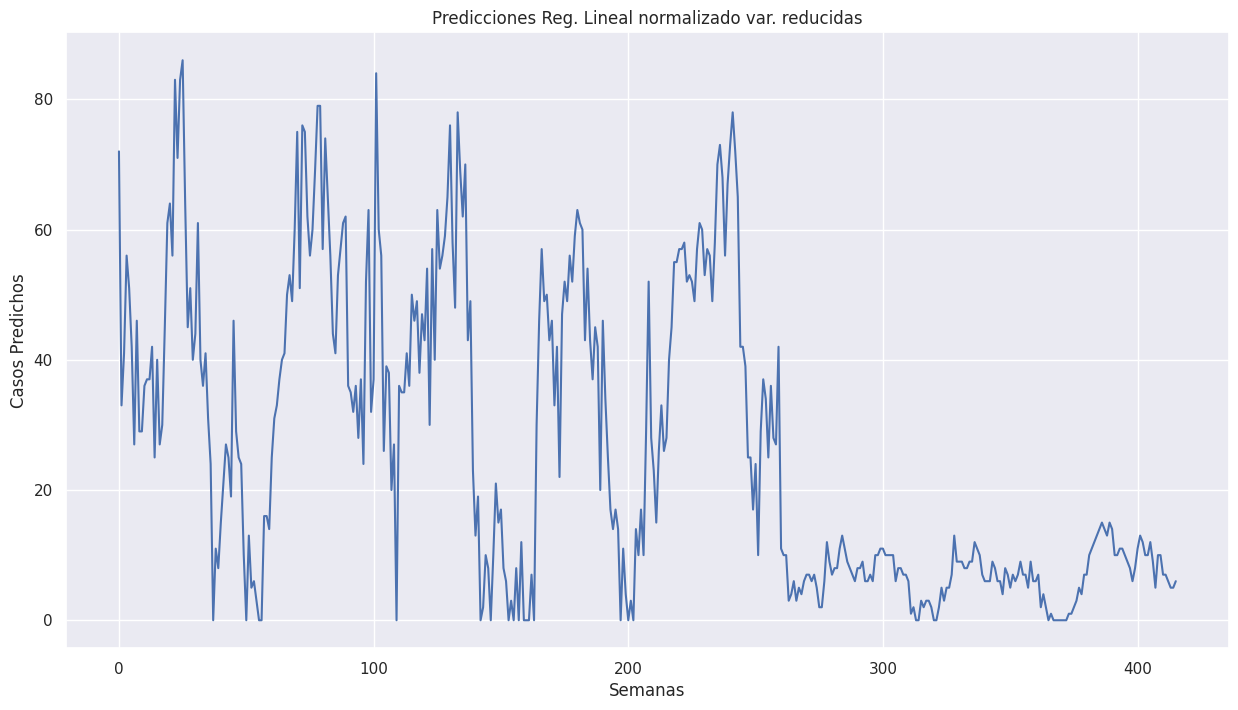

In [37]:
# Reformatear resultados para poderlos descargar
res_linear_model_nor = np.hstack(y_pred_nor_linreg)


plt.plot(res_linear_model_nor)
plt.title("Predicciones Reg. Lineal normalizado var. reducidas")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

In [38]:
 # download_predictions(test, res_linear_model_nor)

A pesar de que el modelo de regresión lineal con los datos normalizados tuvo un desempeño igual al que utiliza los datos crudos en los análisis de Cross Validation, sus resultados de MAE en la plataforma fueron peores, con un valor de 25.44.

## Auto-ARIMA (DATOS NORMALIZADOS - VAR REDUCIDAS)

In [39]:
# Ejecución algoritmo de series temporales Auto-ARIMA y generación de su modelo, recuperado: https://www.section.io/engineering-education/multivariate-time-series-using-auto-arima/
# Nombre del modelo: "norm_arima_model"

norm_sj_TSindex = sj_data.set_index('week_start_date')
norm_sj_TSindex.drop(["city"], axis=1,inplace = True)

arima_model = pm.auto_arima(norm_sj_TSindex['total_cases'],m=4,seasonal=True,start_p=0,start_q=0,max_order=4,test='adf',error_action='ignore',
                      suppress_warnings=True,stepwise=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=8957.641, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=10033.577, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=7532.444, Time=0.63 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=8522.933, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=10374.835, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=7537.460, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=7528.196, Time=2.78 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=7535.023, Time=1.82 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=7532.839, Time=0.83 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=8921.408, Time=0.97 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=7505.176, Time=2.01 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=7512.814, Time=1.02 sec
 ARIMA(2,0,0)(2,0,1)[4] intercept   : AIC=7503.267, Time=2.85 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=7512.145, Time=1.05 sec
 ARIMA(2,0,0)(2,0,2)[4] interce

In [40]:
forecast = arima_model.predict(n_periods = sj_test_data.shape[0], return_conf_int=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


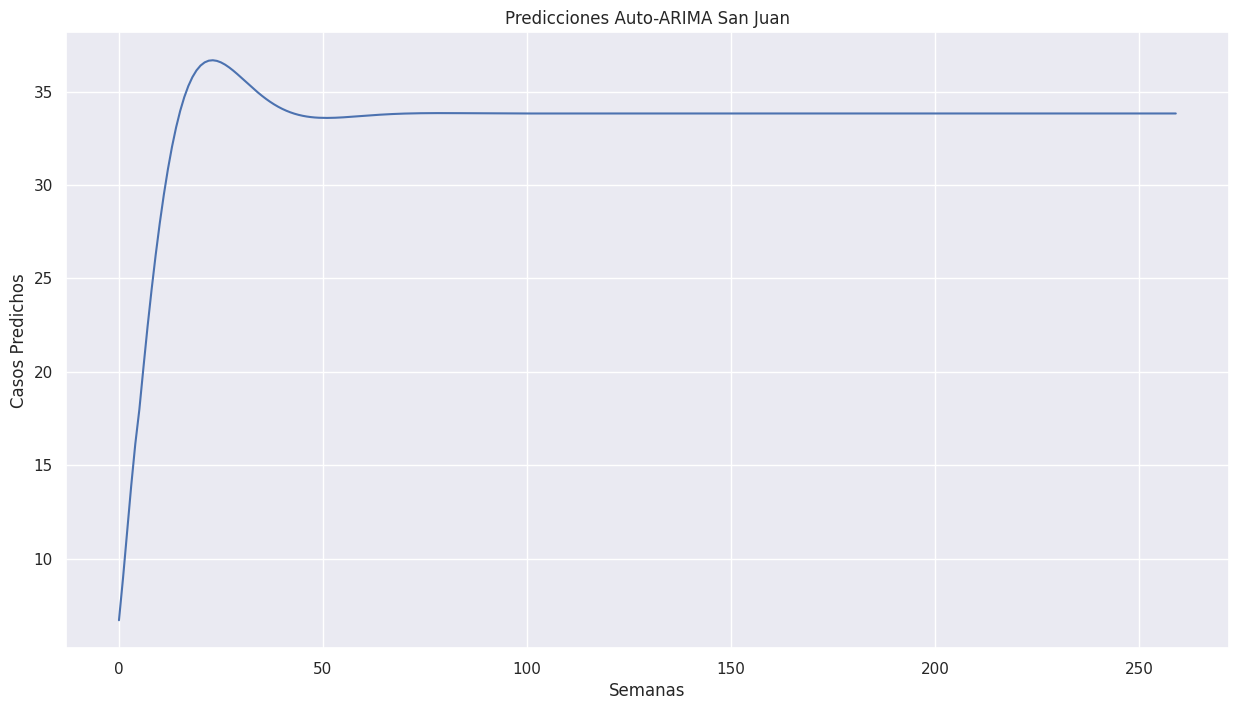

In [41]:
y = forecast[0]

res_arima = np.hstack(y)
plt.plot(res_arima)
plt.title("Predicciones Auto-ARIMA San Juan")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

Ya que los datos de casos totales se pueden trabajar como una serie temporal, se plantea utilizar un modelo de Auto-ARIMA para realizar predicciones.

Los resultados iniciales de este modelo mostrados en la gráfica junto con su alto tiempo de computo hacen que sea descartado.

Es posible que los malos resultados se den por la falta de tratamiento y transformaciones previas en la serie temporal, o por tratar de predecir mucho tiempo hacia adelante, ya que la precisión de estos modelos se degrada con el paso del tiempo.

Sería interesante retomar modelos de predicción con series temporales, pero ya que en esta actividad se propone hacer una experimentación con la mayor cantidad de modelos posibles y esto tomaría mucho tiempo, se decide pasar a otro tipo de modelos.



## LASSO (DATOS CRUDOS - VAR COMPLETAS)

In [42]:
# EJEMPLO: Ejecución del algoritmo LASSO con todos los datos y sin normalizar
# Recuperado de: 
  # https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/
  # https://machinelearningmastery.com/lasso-regression-with-python/
# Nombre del modelo: "raw_lasso_model"
# Resultado MAE: 25.43

SJlasso_reg = Lasso(random_state=0, max_iter=10000)
IQlasso_reg = Lasso(random_state=0, max_iter=10000)

sj_lasso = SJlasso_reg.fit(sj_raw_train, sj_raw_tc)
iq_lasso = IQlasso_reg.fit(iq_raw_train, iq_raw_tc)

#Predicting for X_test
full_lass_pred_sj = sj_lasso.predict(sj_raw_test)
full_lass_pred_iq = iq_lasso.predict(iq_raw_test)

In [43]:
y_pred_full_lasso = []

for pred in full_lass_pred_sj:
  if pred > 0:
    y_pred_full_lasso.append(int(pred))
  else:
    y_pred_full_lasso.append(0)

for pred in full_lass_pred_iq:
  if pred > 0:
    y_pred_full_lasso.append(int(pred))
  else:
    y_pred_full_lasso.append(0)

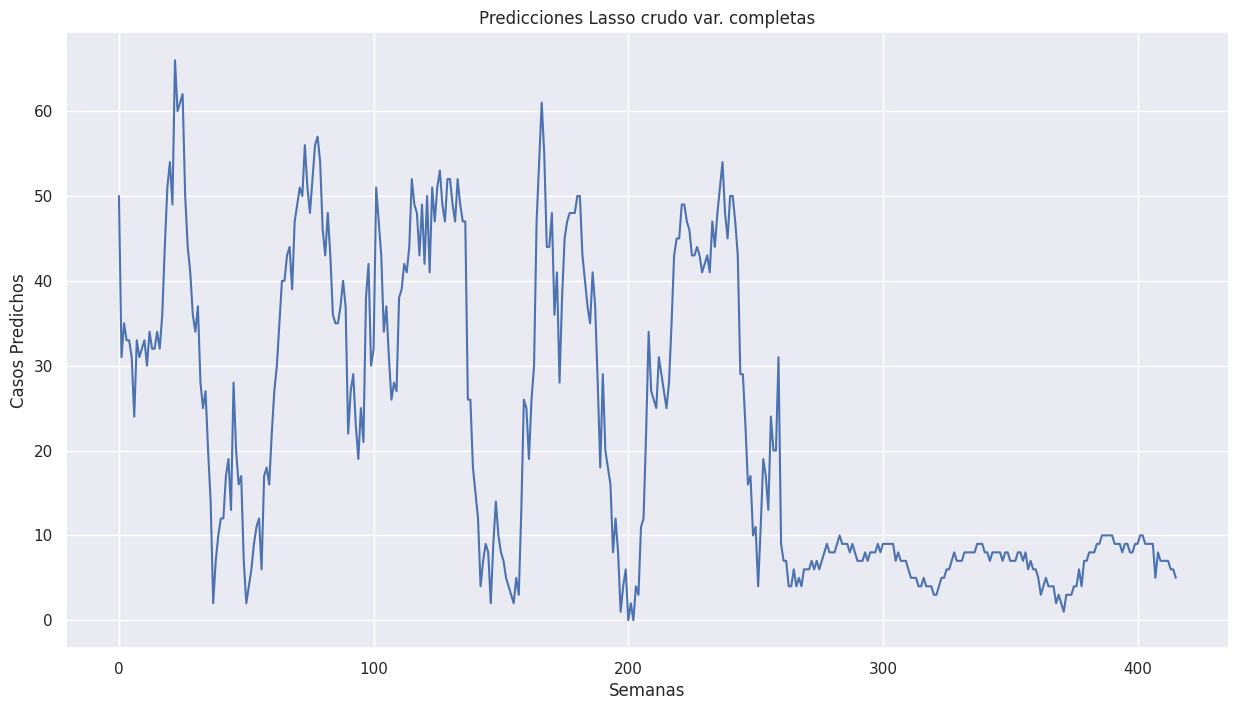

In [44]:
# Reformatear resultados para poderlos descargar
res_full_lasso = np.hstack(y_pred_full_lasso)

plt.plot(res_full_lasso)
plt.title("Predicciones Lasso crudo var. completas")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

In [45]:
# download_predictions(test, res_full_lasso)

Basado en la información consultada sobre los modelos de tipo LASSO y el hecho de que cuentan con capacidades de hacer una selección automática de las variables más útiles, se decide realizar las predicciones con este modelo utilizando el dataset completo en ligar de las variables seleccionadas.

Las predicciones con el modelo LASSO y el dataset completo generan resultados prometedores, con un valor de 25.43

## LASSO (DATOS NORMALIZADOS - VAR COMPLETAS)

In [46]:
# EJEMPLO: Ejecución del algoritmo LASSO con todos los datos normalizados
# Recuperado de: 
  # https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/
  # https://machinelearningmastery.com/lasso-regression-with-python/
# Nombre del modelo: "nor_lasso_model"
# Resultado MAE: 26.58

SJlasso_reg = Lasso(random_state=0, max_iter=10000)
IQlasso_reg = Lasso(random_state=0, max_iter=10000)

sj_lasso = SJlasso_reg.fit(sj_scaled_train, sj_scaled_tc)
iq_lasso = IQlasso_reg.fit(iq_scaled_train, iq_scaled_tc)

#Predicting for X_test
full_normlass_pred_sj = sj_lasso.predict(sj_scaled_test)
full_normlass_pred_iq = iq_lasso.predict(iq_scaled_test)

In [47]:
# Convertir valores a enteros y valores negativos a 0:

y_pred_full_lasso_norm = []

for pred in full_normlass_pred_sj:
  if pred > 0:
    y_pred_full_lasso_norm.append(int(pred))
  else:
    y_pred_full_lasso_norm.append(0)

for pred in full_normlass_pred_iq:
  if pred > 0:
    y_pred_full_lasso_norm.append(int(pred))
  else:
    y_pred_full_lasso_norm.append(0)

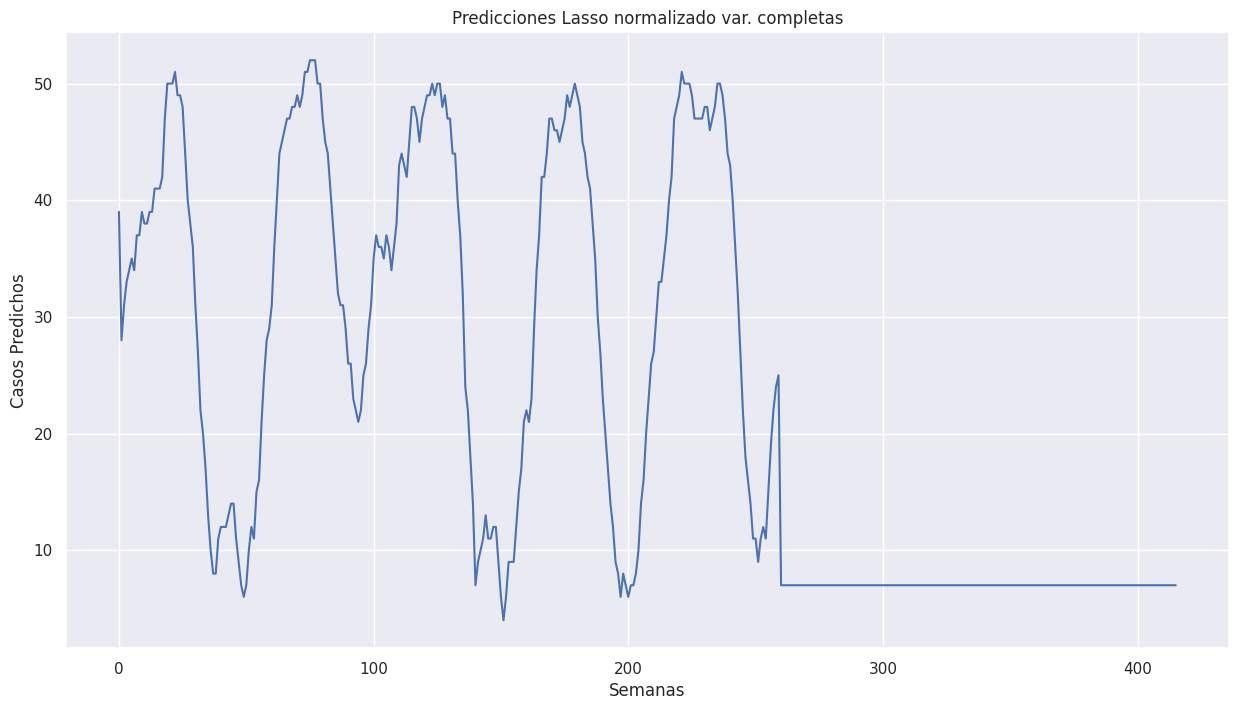

In [48]:
# Reformatear resultados para poderlos descargar
res_full_lasso_nor = np.hstack(y_pred_full_lasso_norm)


plt.plot(res_full_lasso_nor)
plt.title("Predicciones Lasso normalizado var. completas")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

Al visualizar el gráfico generado por el modelo de LASSO con datos normalizados, se puede observar que hubo un problema con las predicciones de la ciudad de Iquitos.

El problema se intenta arreglas de varias formas, pero se mantienen los mismos resultados así que este modelo es descartado por inspección cualitativa de su gráfico.


## Binomial Negativo (DATOS CRUDOS - VAR REDUCIDAS)

---



In [49]:
# Generación de DataFrames con variable "y" para aplicar regresión binomial negativa

X_train_sjnb_model = X_train_rawSJ.copy()
X_train_sjnb_model['y'] = sj_raw_tc
X_sj_raw_crosv['y'] = y_sj_crosv

X_train_iqnb_model = X_train_rawIQ.copy()
X_train_iqnb_model['y'] = iq_raw_tc
X_iq_raw_crosv['y'] = y_iq_crosv

In [50]:
# EJEMPLO: Ejecución del algoritmo Binomial Negativo y generación de su modelo SAN JOSÉ
# Recuperado de: https://github.com/ngbolin/DengAI/blob/master/DengAI.ipynb
# Nombre del modelo: "norm_Negbin_model"
# Resultado MAE: 24.66

def sj_best_nb_model(train, cv):
    formula =  "y ~ 1 + " \
                    "eightweek_mean_maxtemp_c + " \
                    "station_max_temp_c + " \
                    "eightweek_meansp_hum_g_kg + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "eightweek_mean_rel_hum + " \
                    "reanalysis_relative_humidity_percent + " \
                    "eightweek_meanpr_kg_m2 + " \
                    "reanalysis_precip_amt_kg_per_m2 + " \
                    "station_avg_temp_c + " \
                    "reanalysis_max_air_temp_k"
    alpha_grid = np.linspace(0.01, 2, 100)
    
    best_alpha = 0; best_mae = 1000
    
    for alpha in alpha_grid:
        model = smf.glm(formula = formula, data = train,
                        family = sm.families.NegativeBinomial(alpha = alpha))
        nb_model = model.fit()
        
        cv_pred = map(int, map(round, nb_model.predict(cv)))
        cv_pred_ls = list(cv_pred)
        mae = eval_measures.meanabs(cv_pred_ls, cv.y)
        
        if mae < best_mae:
            best_mae = mae
            best_alpha = alpha
            
    total = pd.concat([train, cv])
    
    print('Negative Binomial Model SJ: ', best_mae)
    return smf.glm(formula = formula, data = total,
                   family = sm.families.NegativeBinomial(alpha = best_alpha)).fit()

In [51]:
best_sj_model = sj_best_nb_model(X_train_sjnb_model, X_sj_raw_crosv)

Negative Binomial Model SJ:  20.338709677419356


In [52]:
# EJEMPLO: Ejecución del algoritmo Binomial Negativo y generación de su modelo IQUITOS
# Nombre del modelo: "norm_Negbin_model"
# Resultado MAE: 24.66

def iq_best_nb_model(train, cv):
    formula =  "y ~ 1 + " \
                    "sixweek_mean_mintemp_k + " \
                    "reanalysis_min_air_temp_k + " \
                    "fourweek_meansp_hum_g_kg + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "station_min_temp_c + " \
                    "fourweek_meanpr_kg_m2 + " \
                    "reanalysis_precip_amt_kg_per_m2 + " \
                    "fourweek_mean_rel_hum + " \
                    "reanalysis_relative_humidity_percent + " \
                    "reanalysis_tdtr_k"
    alpha_grid = np.linspace(0.01, 2, 100)
    
    best_alpha = 0; best_mae = 1000
    
    for alpha in alpha_grid:
        model = smf.glm(formula = formula, data = train,
                        family = sm.families.NegativeBinomial(alpha = alpha))
        nb_model = model.fit()
        
        cv_pred = map(int, map(round, nb_model.predict(cv)))
        cv_pred_ls = list(cv_pred)
        mae = eval_measures.meanabs(cv_pred_ls, cv.y)
        
        if mae < best_mae:
            best_mae = mae
            best_alpha = alpha
            
    total = pd.concat([train, cv])
    
    print('Negative Binomial Model IQ: ', best_mae)
    return smf.glm(formula = formula, data = total,
                   family = sm.families.NegativeBinomial(alpha = best_alpha)).fit()

In [53]:
best_iq_model = iq_best_nb_model(X_train_iqnb_model, X_iq_raw_crosv)

Negative Binomial Model IQ:  7.39375


In [54]:
y_sj_nb_raw = pd.Series(map(int, map(round, best_sj_model.predict(X_test_rawSJ))))
y_iq_nb_rw = pd.Series(map(int, map(round, best_iq_model.predict(X_test_rawIQ))))

In [55]:
y_pred_nb_raw = []

for pred in y_sj_nb_raw:
  if pred > 0:
    y_pred_nb_raw.append(pred)
  else:
    y_pred_nb_raw.append(0)

for pred in y_iq_nb_rw:
  if pred > 0:
    y_pred_nb_raw.append(pred)
  else:
    y_pred_nb_raw.append(0)

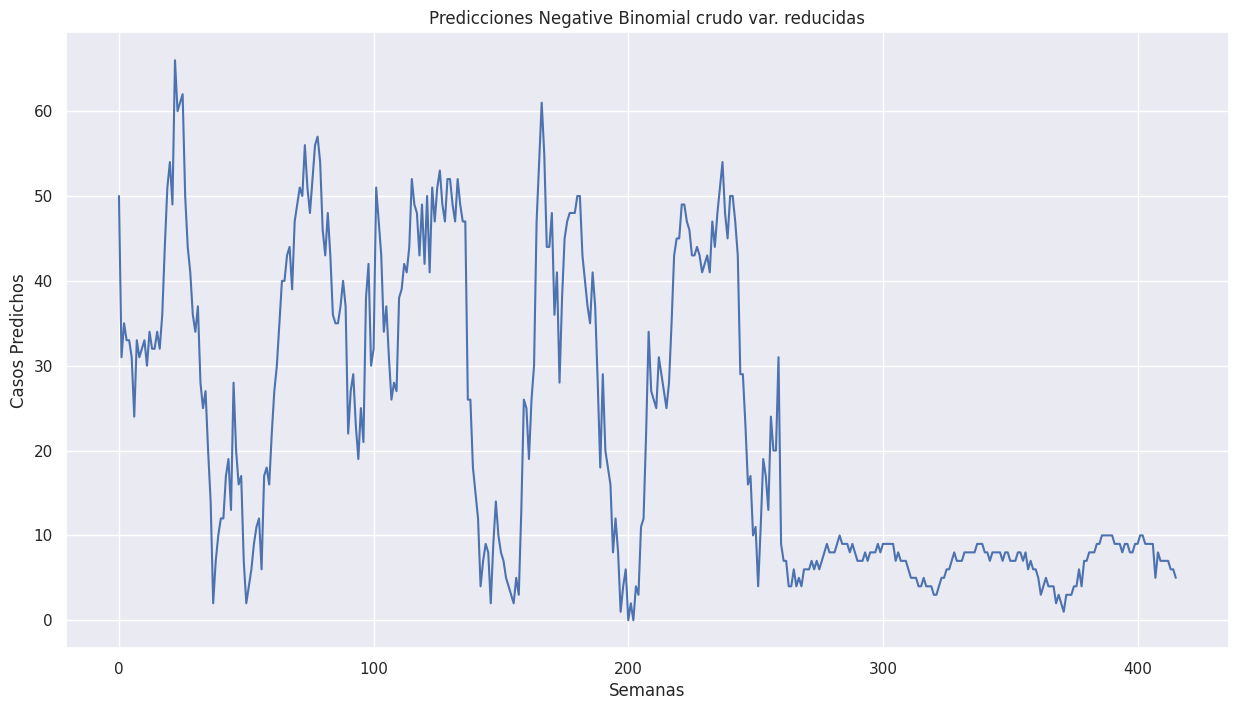

In [56]:
# Reformatear resultados para poderlos descargar
res_raw_nb = np.hstack(y_pred_nb_raw)

plt.plot(res_full_lasso)
plt.title("Predicciones Negative Binomial crudo var. reducidas")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

In [57]:
# download_predictions(test, res_raw_nb)

El modelo de regresión binomial negativa genera los mejores resultados hasta el momento con un puntaje menor a 25. Sin embargo, la página web de donde fué recuperado cuenta con funciones que ajustan su valor de alpha, lo que podría representar una vantaja en comparación con otros modelos que se han calculado con sus valores por defecto.

## Binomial Negativo (DATOS NORMALIZADOS - VAR REDUCIDAS)

In [58]:
# Generación de DataFrames con variable "y" para aplicar regresión binomial negativa

X_train_nor_sj_nb_model = X_train_norSJ.copy()
X_train_nor_sj_nb_model.insert(0, 'y', sj_scaled_tc)
X_sj_scaled_crosv['y'] = y_sj_crosv

X_train_nor_iq_nb_model = X_train_norIQ.copy()
iq_tc_val = list(iq_scaled_tc)
X_train_nor_iq_nb_model.insert(0, 'y', iq_tc_val)
iq_crossval_tc_val = list(y_iq_crosv)
X_iq_scaled_crosv['y'] = iq_crossval_tc_val

In [59]:
best_nor_sj_model = sj_best_nb_model(X_train_nor_sj_nb_model, X_sj_scaled_crosv)

Negative Binomial Model SJ:  20.338709677419356


In [60]:
best_nor_iq_model = iq_best_nb_model(X_train_nor_iq_nb_model, X_iq_scaled_crosv)

Negative Binomial Model IQ:  7.39375


Ya que no parece haber diferencia entre datos normalizados y crudos para los modelos de binomial negativo (Ver resultados de MAE CrossValidation), se decide descartar su implementación con datos normalizados y adelantar en otros tipos de modelo.

## Algoritmo MLP (DATOS CRUDOS - VAR COMPLETAS)

In [61]:
# EJEMPLO: Ejecución del algoritmo MLP y generación de su modelo normalizado
# Nombre del modelo: "raw_mlp_model"
# Resultado MAE: 27.90

sj_mlp_model = MLPRegressor(random_state=0, max_iter=10000)
sj_mlp = sj_mlp_model.fit(sj_raw_train, sj_raw_tc)

iq_mlp_model = MLPRegressor(random_state=0, max_iter=10000)
iq_mlp = iq_mlp_model.fit(iq_raw_train, iq_raw_tc)

#Predicting for X_test
mlp_pred_sj = sj_mlp.predict(sj_raw_test)
mlp_pred_iq = iq_mlp.predict(iq_raw_test)

In [62]:
y_pred_mlp = []

for pred in mlp_pred_sj:
  if pred > 0:
    y_pred_mlp.append(int(pred))
  else:
    y_pred_mlp.append(0)

for pred in mlp_pred_iq:
  if pred > 0:
    y_pred_mlp.append(int(pred))
  else:
    y_pred_mlp.append(0)

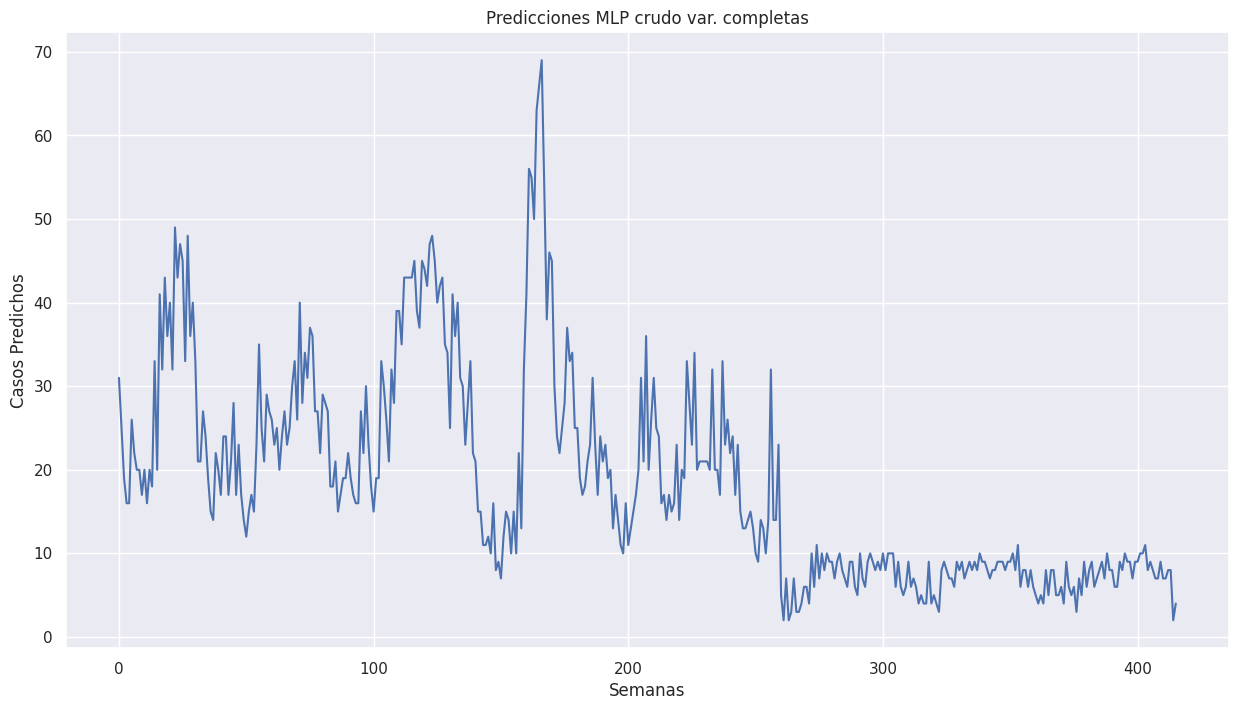

In [63]:
res_mlp = np.hstack(y_pred_mlp)

plt.plot(res_mlp)
plt.title("Predicciones MLP crudo var. completas")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

In [64]:
# download_predictions(test, res_mlp)

El modelo de MLP parace requerir de mayor cantidad de iteraciones que los anteriores, ya que fue necesario modificar su variable "max_iter" para poder obtener los resultados ilustrados anteriormente.

Su resultado de MAE en la competición es de 27.9

## Algoritmo BayesianRegressor (DATOS NORMALIZADOS - VAR COMPLETAS)

In [65]:
# EJEMPLO: Ejecución del algoritmo BayesianRegressor y generación de su modelo normalizado
# Nombre del modelo: "nor_bayreg_model"
# Resultado MAE: 27.19

sj_bayreg_model = linear_model.BayesianRidge()
sj_bayreg = sj_bayreg_model.fit(sj_scaled_train, sj_scaled_tc)

iq_bayreg_model = linear_model.BayesianRidge()
iq_bayreg = iq_bayreg_model.fit(iq_scaled_train, iq_scaled_tc)

#Predicting for X_test
bayreg_pred_sj = sj_bayreg.predict(sj_scaled_test)
bayreg_pred_iq = iq_bayreg.predict(iq_scaled_test)

In [66]:
y_pred_bayreg = []

for pred in bayreg_pred_sj:
  if pred > 0:
    y_pred_bayreg.append(int(pred))
  else:
    y_pred_bayreg.append(0)

for pred in bayreg_pred_iq:
  if pred > 0:
    y_pred_bayreg.append(int(pred))
  else:
    y_pred_bayreg.append(0)

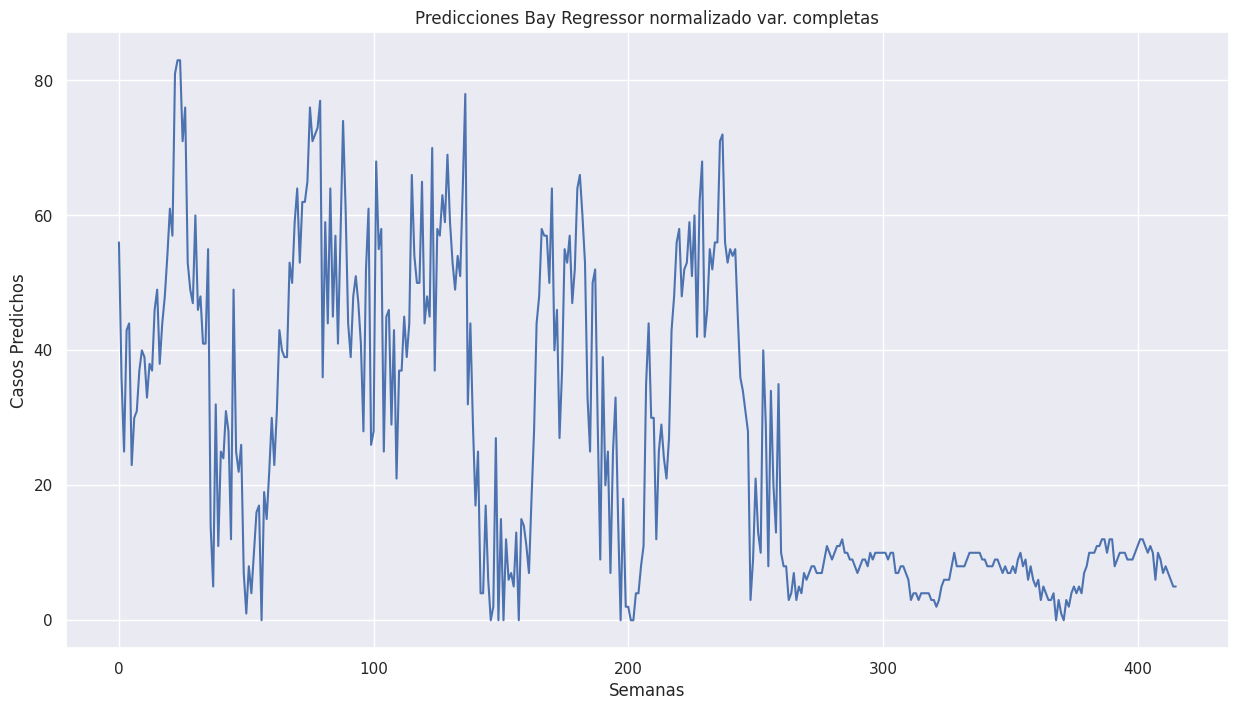

In [67]:
# Reformatear resultados para poderlos descargar
res_bayreg = np.hstack(y_pred_bayreg)


plt.plot(res_bayreg)
plt.title("Predicciones Bay Regressor normalizado var. completas")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

In [68]:
# download_predictions(test, res_bayreg)

## LASSO con ajuste de parametros (DATOS CRUDOS - VAR COMPLETAS)

In [69]:
# División datos de entrenamiento, test y CrossVal SAN JOSÉ e IQUITOS con variables crudas y Dataset Completo.

X_sj_full_raw_crosv, y_sj_full_crosv = sj_raw_train[750:], sj_raw_tc[750:]
print(X_sj_full_raw_crosv.shape, y_sj_full_crosv.shape)


X_iq_full_raw_crosv, y_iq_full_crosv = iq_raw_train[360:], iq_raw_tc[360:]
print(X_iq_full_raw_crosv.shape, y_iq_full_crosv.shape)

(186, 26) (186,)
(160, 26) (160,)


In [70]:
# EJEMPLO: Ejecución del algoritmo LASSO con todos los datos y sin normalizar
# Nombre del modelo: "raw_AdjustedLasso_model"
# Resultado MAE: 26.32

SJlasso_reg = Lasso(random_state=0, max_iter=10000)
IQlasso_reg = Lasso(random_state=0, max_iter=10000)

sj_lasso = SJlasso_reg.fit(sj_raw_train, sj_raw_tc)
iq_lasso = IQlasso_reg.fit(iq_raw_train, iq_raw_tc)

#Predicting for X_test
adj_lass_pred_sj = sj_lasso.predict(sj_raw_test)
adj_lass_pred_iq = iq_lasso.predict(iq_raw_test)

In [71]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10], \
              'tol': [1e-4, 1e-3, 1e-2], \
              'selection': ['cyclic', 'random']}

# Create a GridSearchCV object
sj_grid_search = GridSearchCV(SJlasso_reg, param_grid, cv=10)
iq_grid_search = GridSearchCV(IQlasso_reg, param_grid, cv=10) # https://machinelearningmastery.com/lasso-regression-with-python/

# Fit the GridSearchCV object to the training data
sj_grid_search.fit(sj_raw_train, sj_raw_tc)
iq_grid_search.fit(iq_raw_train, iq_raw_tc)

sj_bestparam = sj_grid_search.best_params_
iq_bestparam = iq_grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.500e+04, tolerance: 2.299e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.726e+05, tolerance: 2.442e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.957e+05, tolerance: 9.626e

In [72]:
# Imprimir mejores parametros para reentrenar modelos:

print("SJ mejores param: ", sj_bestparam)
print("IQ mejores param: ", iq_bestparam)

SJ mejores param:  {'alpha': 10, 'selection': 'cyclic', 'tol': 0.001}
IQ mejores param:  {'alpha': 0.1, 'selection': 'random', 'tol': 0.01}


In [73]:
# Volver a enrenar con parametros ajustados:

SJlasso_reg = Lasso(random_state=0, max_iter=10000, alpha = 10, selection = 'cyclic', tol = 0.001)
IQlasso_reg = Lasso(random_state=0, max_iter=10000, alpha = 0.001, selection = 'random', tol = 0.01)

sj_lasso_bestparam = SJlasso_reg.fit(sj_raw_train, sj_raw_tc)
iq_lasso_bestparam = IQlasso_reg.fit(iq_raw_train, iq_raw_tc)

#Predicting for X_test
bestparam_lass_pred_sj = sj_lasso_bestparam.predict(sj_raw_test)
bestparam_lass_pred_iq = iq_lasso_bestparam.predict(iq_raw_test)

In [74]:
y_pred_bestparam_lasso = []

for pred in bestparam_lass_pred_sj:
  if pred > 0:
    y_pred_bestparam_lasso.append(int(pred))
  else:
    y_pred_bestparam_lasso.append(0)

for pred in bestparam_lass_pred_iq:
  if pred > 0:
    y_pred_bestparam_lasso.append(int(pred))
  else:
    y_pred_bestparam_lasso.append(0)

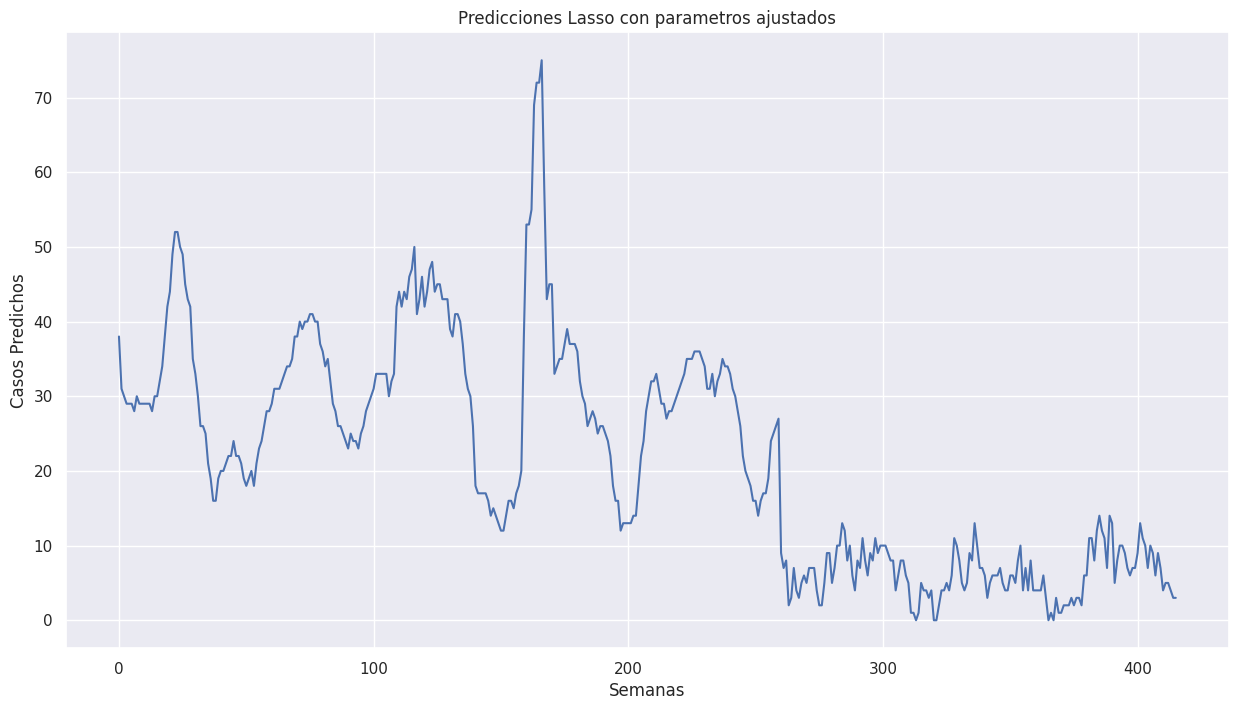

In [75]:
# Reformatear resultados para poderlos descargar
res_bestparam_lasso = np.hstack(y_pred_bestparam_lasso)

plt.plot(res_bestparam_lasso)
plt.title("Predicciones Lasso con parametros ajustados")
plt.ylabel("Casos Predichos")
plt.xlabel("Semanas")
plt.show()

In [76]:
# download_predictions(test, res_bestparam_lasso)

Ya que el modelo de LASSO parecía ajustarse bastante bien al tipo de problema presentado en el enunciado de la competición y muestra buenos resultados de MAE al subirlo en la plataforma, se plantea generar un ajuste de hiperparámetros en el mismo utilizando la herramienta "GridSearchCV", sin embargo, los resultados de estas predicciones son peores que los del modelo LASSO inicial, con un valor de 26.32.

---
# Conclusiones
---

| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo | Hiperparámetros | Características
| --- | --- | --- | --- | --- | --- |
| Final: Raw_NBin | 24.66 | 20,33/7.39 | Reg. Binomial Negativa | - | -
| Raw_LRM | 25.03 | 17.45 | Regresión Lineal | Por Defecto | -
| Nor_LRM | 25.44 | 17.45 | Regresión Lineal | Por Defecto | -
| ARIMA | N/A | N/A | Auto-ARIMA | N/A | -
| Raw_LASSO | 25.43 | N/A | Regresión Lasso | Por Defecto | -
| Nor_LASSO | N/A | N/A | Regresión Lasso | Por Defecto | -
| Nor_NBin | N/A | 20,33/7.39 | Reg. Binomial Negativa | - | -
| MLP | 27.9 | N/A | Multi Layer Perceptron | Por Defecto | -
| Bay_Reg | 27.19 | N/A | Regresión Ridge Bayesiana | Por Defecto | -
| Adj_LASSO | 26.32 | N/A | Regresión Lasso | SJ('alpha':10,'selection':'cyclic','tol':0.001) IQ('alpha':0.1,'selection':'random','tol':0.01) | -

Conclusiones:


1.   El entendimiento de contexto y del problema a tratar es clave antes de realizar tareas de aprendizaje supervisado o no supervisado.

2.   Es importante tratar de entender el por qué de los resultados y graficar las variables obtenidas para poder hacer inspecciones visuales.

3. La adición de variables nuevas con mejores valores de correlación puede mejorar considerablemente el desempeño de un modelo predictivo.

4. Se pueden presentar grandes diferencias entre los valores del MAE de validación comparado con el obtenido en la página web de la competencia.



---
# Competición
---

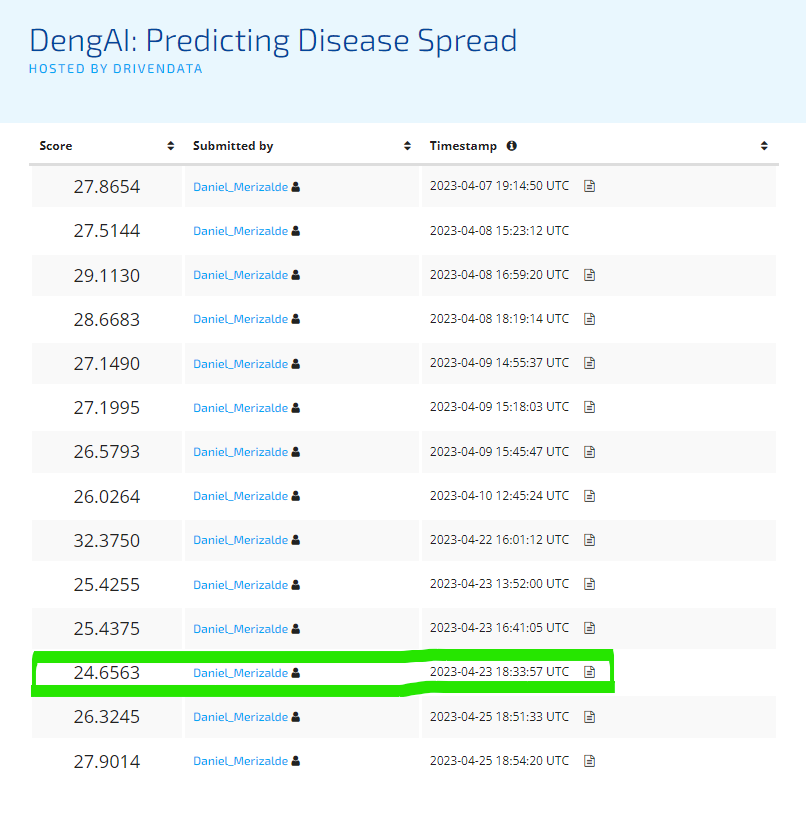

* Nombre de usuario DrivenData: Daniel_Merizalde
* Mejor puntaje MAE: 24.6563